# Lie Groups: The Special Orthogonal Group SO(3)

## Introduction

The **special orthogonal group** $\mathrm{SO}(3)$ is a fundamental object in mathematics and physics, describing all proper rotations in three-dimensional Euclidean space. It is a **Lie group**—a smooth manifold that is also a group, where the group operations (multiplication and inversion) are smooth maps.

## Definition

The special orthogonal group in three dimensions is defined as:

$$\mathrm{SO}(3) = \{R \in \mathbb{R}^{3 \times 3} : R^T R = I, \det(R) = 1\}$$

where $I$ is the $3 \times 3$ identity matrix. The two conditions ensure:
- **Orthogonality** ($R^T R = I$): The matrix preserves inner products and lengths
- **Unit determinant** ($\det(R) = 1$): The transformation preserves orientation (no reflections)

## The Lie Algebra $\mathfrak{so}(3)$

Every Lie group has an associated **Lie algebra**, which captures the infinitesimal structure of the group. For $\mathrm{SO}(3)$, the Lie algebra is:

$$\mathfrak{so}(3) = \{A \in \mathbb{R}^{3 \times 3} : A^T = -A\}$$

This is the space of $3 \times 3$ **skew-symmetric matrices**. Any element $A \in \mathfrak{so}(3)$ can be written as:

$$A = \begin{pmatrix} 0 & -\omega_3 & \omega_2 \\ \omega_3 & 0 & -\omega_1 \\ -\omega_2 & \omega_1 & 0 \end{pmatrix} = [\boldsymbol{\omega}]_\times$$

where $\boldsymbol{\omega} = (\omega_1, \omega_2, \omega_3)^T$ is the angular velocity vector, and $[\cdot]_\times$ denotes the **hat map** (skew-symmetric matrix representation).

## The Exponential Map

The **exponential map** connects the Lie algebra to the Lie group:

$$\exp: \mathfrak{so}(3) \to \mathrm{SO}(3)$$

For $A = [\boldsymbol{\omega}]_\times$ with $\|\boldsymbol{\omega}\| = \theta$, the **Rodrigues' rotation formula** gives:

$$\exp([\boldsymbol{\omega}]_\times) = I + \frac{\sin\theta}{\theta}[\boldsymbol{\omega}]_\times + \frac{1 - \cos\theta}{\theta^2}[\boldsymbol{\omega}]_\times^2$$

This formula shows that any rotation matrix can be obtained by exponentiating a skew-symmetric matrix.

## Geometric Interpretation

The group $\mathrm{SO}(3)$ is topologically equivalent to the 3-dimensional **real projective space** $\mathbb{RP}^3$, which is diffeomorphic to a solid ball of radius $\pi$ with antipodal points on the boundary identified. This reflects the fact that a rotation by angle $\theta$ about axis $\hat{\mathbf{n}}$ is the same as a rotation by $2\pi - \theta$ about $-\hat{\mathbf{n}}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Set random seed for reproducibility
np.random.seed(42)

## Implementation: Core SO(3) Operations

We now implement the fundamental operations for working with $\mathrm{SO}(3)$ and its Lie algebra $\mathfrak{so}(3)$.

In [2]:
def hat(omega):
    """
    Hat map: Convert angular velocity vector to skew-symmetric matrix.
    
    Maps R^3 -> so(3)
    
    Parameters:
    -----------
    omega : array-like, shape (3,)
        Angular velocity vector (omega_1, omega_2, omega_3)
    
    Returns:
    --------
    ndarray, shape (3, 3)
        Skew-symmetric matrix [omega]_x
    """
    omega = np.asarray(omega)
    return np.array([
        [0, -omega[2], omega[1]],
        [omega[2], 0, -omega[0]],
        [-omega[1], omega[0], 0]
    ])


def vee(A):
    """
    Vee map: Convert skew-symmetric matrix to angular velocity vector.
    
    Maps so(3) -> R^3 (inverse of hat map)
    
    Parameters:
    -----------
    A : ndarray, shape (3, 3)
        Skew-symmetric matrix
    
    Returns:
    --------
    ndarray, shape (3,)
        Angular velocity vector
    """
    return np.array([A[2, 1], A[0, 2], A[1, 0]])


def rodrigues_rotation(omega):
    """
    Compute rotation matrix using Rodrigues' formula.
    
    Implements the exponential map: exp([omega]_x) -> SO(3)
    
    Parameters:
    -----------
    omega : array-like, shape (3,)
        Rotation vector (axis * angle)
    
    Returns:
    --------
    ndarray, shape (3, 3)
        Rotation matrix in SO(3)
    """
    omega = np.asarray(omega)
    theta = np.linalg.norm(omega)
    
    if theta < 1e-10:
        # For small angles, use first-order approximation
        return np.eye(3) + hat(omega)
    
    omega_hat = hat(omega)
    # Rodrigues' formula
    R = (np.eye(3) + 
         (np.sin(theta) / theta) * omega_hat + 
         ((1 - np.cos(theta)) / theta**2) * omega_hat @ omega_hat)
    return R


def log_so3(R):
    """
    Compute the logarithm map: SO(3) -> so(3).
    
    Returns the rotation vector omega such that R = exp([omega]_x)
    
    Parameters:
    -----------
    R : ndarray, shape (3, 3)
        Rotation matrix in SO(3)
    
    Returns:
    --------
    ndarray, shape (3,)
        Rotation vector (axis * angle)
    """
    # Compute rotation angle
    cos_theta = (np.trace(R) - 1) / 2
    cos_theta = np.clip(cos_theta, -1, 1)  # Numerical stability
    theta = np.arccos(cos_theta)
    
    if theta < 1e-10:
        # Near identity
        return np.zeros(3)
    elif np.abs(theta - np.pi) < 1e-10:
        # Near pi rotation - extract axis from R + I
        B = R + np.eye(3)
        axis = B[:, np.argmax(np.sum(B**2, axis=0))]
        axis = axis / np.linalg.norm(axis)
        return theta * axis
    else:
        # General case
        omega_hat = (theta / (2 * np.sin(theta))) * (R - R.T)
        return vee(omega_hat)

## Verification of Group Properties

Let us verify that our rotation matrices satisfy the defining properties of $\mathrm{SO}(3)$.

In [3]:
# Generate a random rotation vector
omega_test = np.random.randn(3)
R_test = rodrigues_rotation(omega_test)

# Check orthogonality: R^T R = I
orthogonality_error = np.linalg.norm(R_test.T @ R_test - np.eye(3))
print(f"Orthogonality error ||R^T R - I||: {orthogonality_error:.2e}")

# Check determinant = 1
det_R = np.linalg.det(R_test)
print(f"Determinant of R: {det_R:.10f}")

# Verify exponential-logarithm consistency
omega_recovered = log_so3(R_test)
R_recovered = rodrigues_rotation(omega_recovered)
recovery_error = np.linalg.norm(R_test - R_recovered)
print(f"Log-Exp recovery error ||R - exp(log(R))||: {recovery_error:.2e}")

Orthogonality error ||R^T R - I||: 1.07e-16
Determinant of R: 1.0000000000
Log-Exp recovery error ||R - exp(log(R))||: 7.85e-17


## Visualization of SO(3) Rotations

We visualize the effect of rotations on a coordinate frame, demonstrating:
1. Rotations about the three principal axes
2. The composition of rotations (non-commutativity)
3. The exponential map trajectory

In [4]:
class Arrow3D(FancyArrowPatch):
    """Custom 3D arrow for visualization."""
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)


def draw_frame(ax, R, origin=np.zeros(3), scale=1.0, alpha=1.0, label_prefix=''):
    """
    Draw a coordinate frame rotated by R.
    
    Parameters:
    -----------
    ax : Axes3D
        Matplotlib 3D axes
    R : ndarray, shape (3, 3)
        Rotation matrix
    origin : ndarray, shape (3,)
        Origin of the frame
    scale : float
        Length of the axes
    alpha : float
        Transparency
    label_prefix : str
        Prefix for axis labels
    """
    colors = ['r', 'g', 'b']
    labels = ['x', 'y', 'z']
    
    for i in range(3):
        direction = R[:, i] * scale
        ax.quiver(origin[0], origin[1], origin[2],
                  direction[0], direction[1], direction[2],
                  color=colors[i], alpha=alpha, arrow_length_ratio=0.1,
                  linewidth=2)

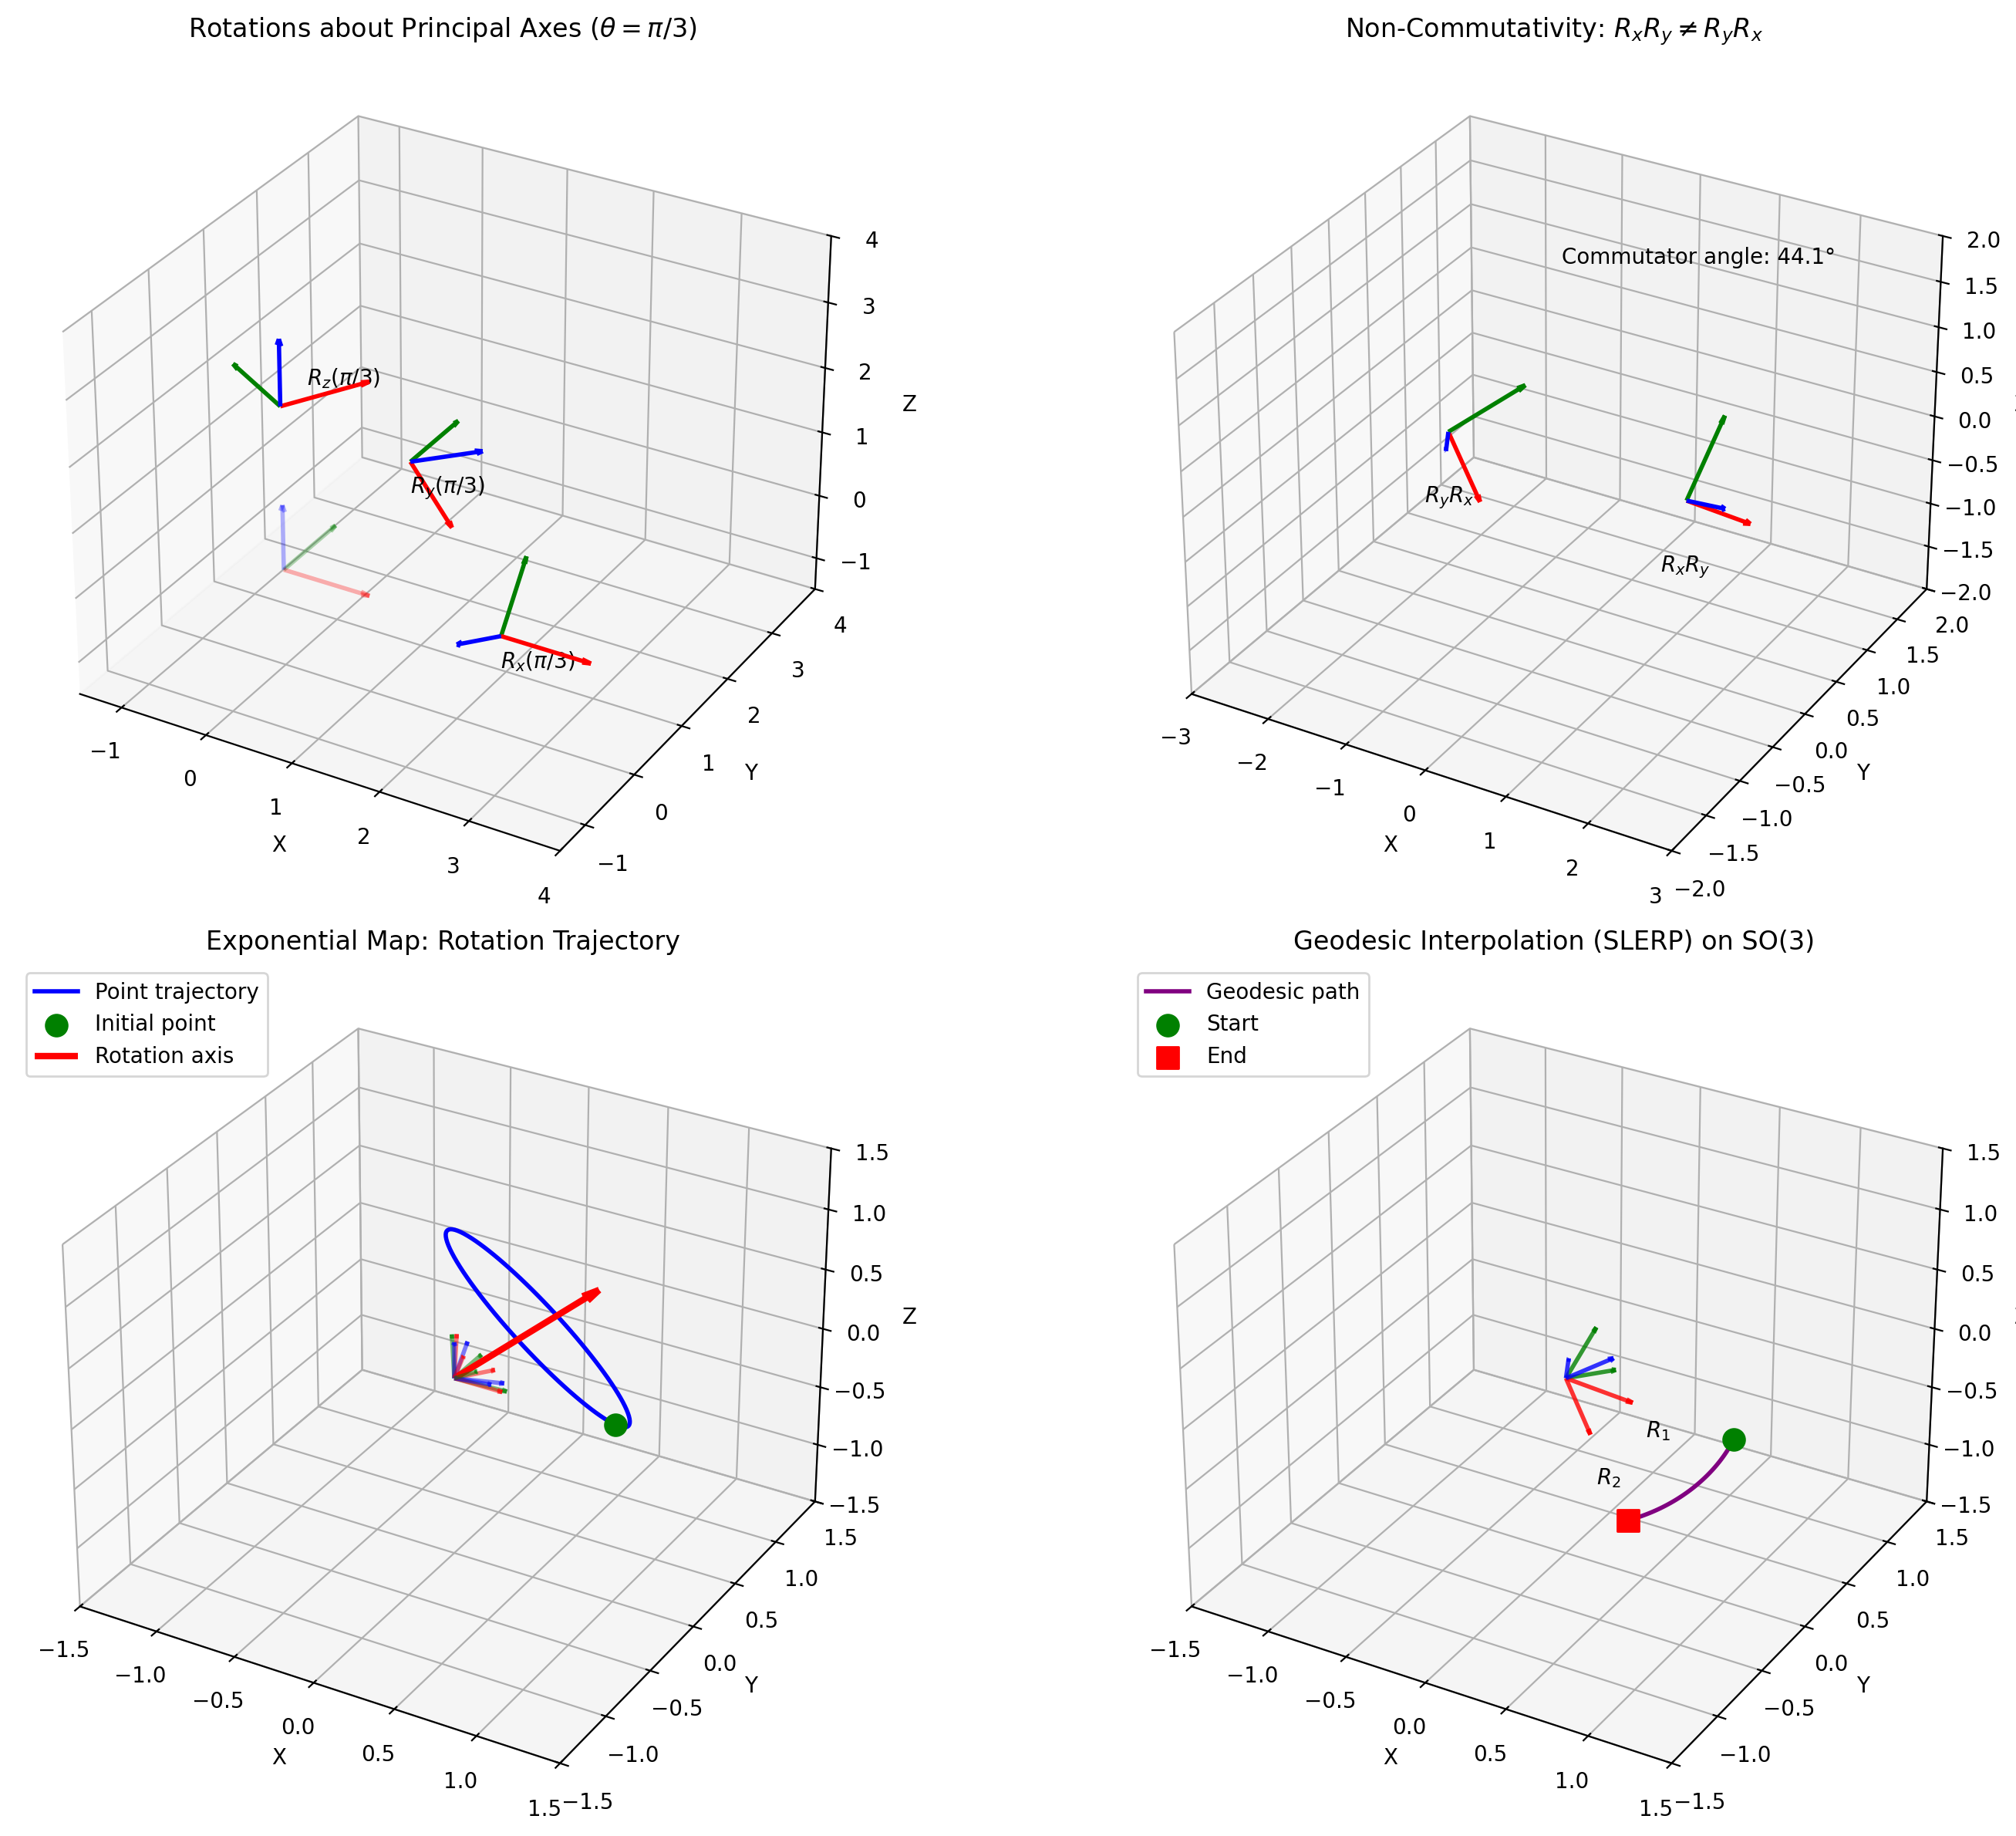

Plot saved to plot.png


In [5]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# Subplot 1: Rotations about principal axes
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.set_title(r'Rotations about Principal Axes ($\theta = \pi/3$)', fontsize=12)

# Identity frame
draw_frame(ax1, np.eye(3), alpha=0.3)

# Rotation about x-axis (red)
theta = np.pi / 3
Rx = rodrigues_rotation([theta, 0, 0])
draw_frame(ax1, Rx, origin=np.array([2.5, 0, 0]))
ax1.text(2.5, 0, -0.5, r'$R_x(\pi/3)$', fontsize=10)

# Rotation about y-axis (green)
Ry = rodrigues_rotation([0, theta, 0])
draw_frame(ax1, Ry, origin=np.array([0, 2.5, 0]))
ax1.text(0, 2.5, -0.5, r'$R_y(\pi/3)$', fontsize=10)

# Rotation about z-axis (blue)
Rz = rodrigues_rotation([0, 0, theta])
draw_frame(ax1, Rz, origin=np.array([0, 0, 2.5]))
ax1.text(0, 0.5, 2.5, r'$R_z(\pi/3)$', fontsize=10)

ax1.set_xlim([-1.5, 4])
ax1.set_ylim([-1.5, 4])
ax1.set_zlim([-1.5, 4])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Subplot 2: Non-commutativity demonstration
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.set_title(r'Non-Commutativity: $R_x R_y \neq R_y R_x$', fontsize=12)

theta1, theta2 = np.pi/4, np.pi/3
Rx = rodrigues_rotation([theta1, 0, 0])
Ry = rodrigues_rotation([0, theta2, 0])

# R_x then R_y
RxRy = Ry @ Rx
draw_frame(ax2, RxRy, origin=np.array([-1.5, 0, 0]), scale=0.8)
ax2.text(-1.5, 0, -0.8, r'$R_y R_x$', fontsize=10, ha='center')

# R_y then R_x  
RyRx = Rx @ Ry
draw_frame(ax2, RyRx, origin=np.array([1.5, 0, 0]), scale=0.8)
ax2.text(1.5, 0, -0.8, r'$R_x R_y$', fontsize=10, ha='center')

# Show the commutator effect
commutator = RxRy @ RyRx.T  # [Rx, Ry] = RxRy * (RyRx)^T
commutator_angle = np.arccos(np.clip((np.trace(commutator) - 1) / 2, -1, 1))
ax2.text(0, 2, 1, f'Commutator angle: {np.degrees(commutator_angle):.1f}°', 
         fontsize=10, ha='center')

ax2.set_xlim([-3, 3])
ax2.set_ylim([-2, 2])
ax2.set_zlim([-2, 2])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Subplot 3: Exponential map trajectory
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.set_title('Exponential Map: Rotation Trajectory', fontsize=12)

# Fixed rotation axis
axis = np.array([1, 1, 1]) / np.sqrt(3)

# Track a point under rotation
point = np.array([1, 0, 0])
thetas = np.linspace(0, 2*np.pi, 100)
trajectory = np.zeros((len(thetas), 3))

for i, t in enumerate(thetas):
    R = rodrigues_rotation(t * axis)
    trajectory[i] = R @ point

ax3.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
         'b-', linewidth=2, label='Point trajectory')
ax3.scatter([point[0]], [point[1]], [point[2]], c='g', s=100, 
            label='Initial point', zorder=5)

# Draw rotation axis
ax3.quiver(0, 0, 0, axis[0], axis[1], axis[2], color='r', 
           arrow_length_ratio=0.1, linewidth=3, label='Rotation axis')

# Draw intermediate frames
for t in [0, np.pi/2, np.pi, 3*np.pi/2]:
    R = rodrigues_rotation(t * axis)
    draw_frame(ax3, R, scale=0.3, alpha=0.5)

ax3.set_xlim([-1.5, 1.5])
ax3.set_ylim([-1.5, 1.5])
ax3.set_zlim([-1.5, 1.5])
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.legend(loc='upper left')

# Subplot 4: Geodesic interpolation (SLERP)
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.set_title('Geodesic Interpolation (SLERP) on SO(3)', fontsize=12)

# Two random rotations
R1 = rodrigues_rotation([0.5, 0.3, 0.1])
R2 = rodrigues_rotation([-0.2, 0.8, -0.4])

def slerp_so3(R1, R2, t):
    """
    Spherical linear interpolation between two rotations.
    
    R(t) = R1 * exp(t * log(R1^T * R2))
    """
    R_rel = R1.T @ R2
    omega = log_so3(R_rel)
    return R1 @ rodrigues_rotation(t * omega)

# Interpolate and track a point
point = np.array([1, 0, 0])
ts = np.linspace(0, 1, 50)
geodesic = np.zeros((len(ts), 3))

for i, t in enumerate(ts):
    R_t = slerp_so3(R1, R2, t)
    geodesic[i] = R_t @ point

ax4.plot(geodesic[:, 0], geodesic[:, 1], geodesic[:, 2], 
         'purple', linewidth=2, label='Geodesic path')

# Draw start and end frames
draw_frame(ax4, R1, scale=0.4, alpha=0.8)
ax4.text(0.5, 0, -0.3, r'$R_1$', fontsize=10)
draw_frame(ax4, R2, scale=0.4, alpha=0.8)
end_point = R2 @ np.array([0.5, 0, 0])
ax4.text(end_point[0], end_point[1], end_point[2] - 0.3, r'$R_2$', fontsize=10)

# Mark start and end points
ax4.scatter([geodesic[0, 0]], [geodesic[0, 1]], [geodesic[0, 2]], 
            c='green', s=100, marker='o', label='Start')
ax4.scatter([geodesic[-1, 0]], [geodesic[-1, 1]], [geodesic[-1, 2]], 
            c='red', s=100, marker='s', label='End')

ax4.set_xlim([-1.5, 1.5])
ax4.set_ylim([-1.5, 1.5])
ax4.set_zlim([-1.5, 1.5])
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.legend(loc='upper left')

plt.tight_layout()
plt.savefig('lie_groups_so3_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to plot.png")

## Lie Bracket and the Adjoint Representation

The **Lie bracket** on $\mathfrak{so}(3)$ is the matrix commutator:

$$[A, B] = AB - BA$$

For the basis elements $\{E_1, E_2, E_3\}$ (skew-symmetric matrices corresponding to unit vectors), the Lie bracket satisfies:

$$[E_i, E_j] = \epsilon_{ijk} E_k$$

where $\epsilon_{ijk}$ is the Levi-Civita symbol. This is isomorphic to the cross product:

$$[\boldsymbol{\omega}_1]_\times [\boldsymbol{\omega}_2]_\times - [\boldsymbol{\omega}_2]_\times [\boldsymbol{\omega}_1]_\times = [\boldsymbol{\omega}_1 \times \boldsymbol{\omega}_2]_\times$$

In [6]:
def lie_bracket(A, B):
    """Compute the Lie bracket [A, B] = AB - BA."""
    return A @ B - B @ A


# Verify isomorphism with cross product
omega1 = np.array([1, 0, 0])
omega2 = np.array([0, 1, 0])

# Lie bracket in so(3)
bracket = lie_bracket(hat(omega1), hat(omega2))
bracket_vector = vee(bracket)

# Cross product in R^3
cross = np.cross(omega1, omega2)

print(f"ω₁ = {omega1}")
print(f"ω₂ = {omega2}")
print(f"")
print(f"Lie bracket [ω₁, ω₂]^∨ = {bracket_vector}")
print(f"Cross product ω₁ × ω₂  = {cross}")
print(f"")
print(f"Isomorphism verified: {np.allclose(bracket_vector, cross)}")

ω₁ = [1 0 0]
ω₂ = [0 1 0]

Lie bracket [ω₁, ω₂]^∨ = [0 0 1]
Cross product ω₁ × ω₂  = [0 0 1]

Isomorphism verified: True


## Applications in Physics

$\mathrm{SO}(3)$ appears throughout physics:

1. **Classical Mechanics**: Describes the orientation of rigid bodies; the angular velocity $\boldsymbol{\omega}$ lives in $\mathfrak{so}(3)$

2. **Quantum Mechanics**: The group $\mathrm{SU}(2)$ (double cover of $\mathrm{SO}(3)$) describes spin-1/2 particles

3. **Robotics**: Used for describing end-effector orientations and inverse kinematics

4. **Computer Graphics**: Quaternions (related to $\mathrm{SU}(2)$) are used for smooth rotational interpolation

## Summary

We have explored the Lie group $\mathrm{SO}(3)$ and its Lie algebra $\mathfrak{so}(3)$:

- **Definition**: $\mathrm{SO}(3)$ consists of orthogonal matrices with determinant 1
- **Lie algebra**: $\mathfrak{so}(3)$ is the space of skew-symmetric matrices
- **Exponential map**: Rodrigues' formula connects $\mathfrak{so}(3)$ to $\mathrm{SO}(3)$
- **Non-commutativity**: Rotations do not commute, reflected in the non-trivial Lie bracket
- **Geometry**: $\mathrm{SO}(3)$ is a 3-dimensional compact Lie group diffeomorphic to $\mathbb{RP}^3$

The interplay between the group and its algebra provides powerful computational tools for working with rotations in three dimensions.